In [32]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import Audio

import torch
from torch.utils.data import DataLoader

In [2]:
sys.path.append("../src")
import prediction
from dataset import FSDDataset
from model import ConformerModel, GRUModel, ResNet, CRNN

In [7]:
audio_path = '../../dataset'
metadata_path = '../meta/training_not_mout.csv'

## prediction and plot

In [4]:
def plot_confusion_matrix(predict, ground_truth, title=None, cmap=plt.cm.Blues, model_name=None):
    cm = confusion_matrix(predict, ground_truth)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel("Predicted")
    plt.xlabel("Ground truth")
#     plt.savefig(model_name + '.png')
    plt.show()

In [5]:
# def generate_confusion_matrix(pred_by_fold: np.ndarray, truth_path: str, model_name: str):
#     test_truth = pd.read_csv(truth_path)

#     pred = pred_by_fold.sum(axis=0) // 3

#     truth_values = test_truth['label'].values
#     title = f'acc: {str(accuracy_score(truth_values, pred))}'
#     plot_confusion_matrix(pred, truth_values, title=title, model_name=model_name)

### ConformerModel

In [8]:
dataset = FSDDataset(
    audio_path=audio_path,
    metadata_path=metadata_path,
    win_size_rate=0.025,
    overlap=0.5,
    n_mels=32,
    training=False,
    n_channels=1,
)
dataloader = DataLoader(dataset, batch_size=256, pin_memory=True)

device = torch.device('cuda')
model_name = 'ConformerModel'
weight_path = '../results/20210627092226/'

In [9]:
preds_by_fold = []
for fold in range(3):
    pred = prediction.run(model_name, weight_path + f'fold{fold}-best.pt', dataloader, device)
    preds_by_fold.append(pred)

In [11]:
preds_by_fold = np.array(preds_by_fold)
# generate_confusion_matrix(preds_by_fold, '../meta/test_truth.csv', model_name)
conf_res = preds_by_fold

In [19]:
labels = pd.read_csv(metadata_path)['label'].values
conf_pred = conf_res.sum(axis=0) // 3

In [25]:
corr = 0
incorr = []
for i in range(len(labels)):
    if labels[i] != conf_pred[i]:
        incorr.append(i)
    else:
        corr += 1

In [26]:
acc = corr / len(labels)
acc

0.9729629629629629

In [27]:
len(incorr)

73

In [28]:
def mel_spec(input: np.ndarray, sr: int, win_size: int, hop_len: int, n_mels: int, fmax: int = 4096) -> np.ndarray:
    mel = librosa.feature.melspectrogram(
        y=input, sr=sr, n_mels=n_mels, fmax=fmax, n_fft=win_size, win_length=win_size, hop_length=hop_len)
    log_mel = librosa.amplitude_to_db(mel)

    # reverse
    log_mel = log_mel[::-1] - np.zeros_like(log_mel)

    return log_mel

In [33]:
path = pd.read_csv(metadata_path)['path']
y, sr = librosa.load(path[incorr[0]])
Audio(y, rate=sr)

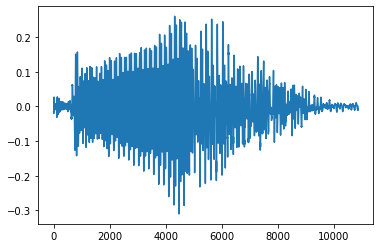

In [34]:
plt.plot(y)

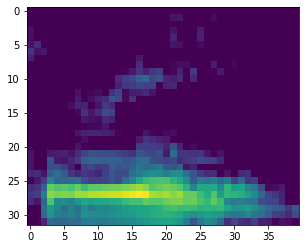

In [35]:
win_size = int(sr*0.025)
overlap = 0.5
n_mels = 32

logmel = mel_spec(y, sr, win_size, int(win_size*overlap), n_mels)
logmel = np.float32(logmel[:, :])
plt.imshow(logmel)

In [37]:
path = pd.read_csv(metadata_path)['path']

In [51]:
y, sr = librosa.load(path[1010])
Audio(y, rate=sr)

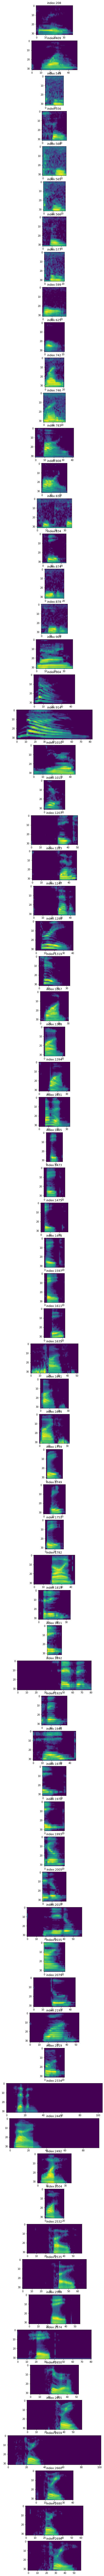

In [52]:
fig, axes = plt.subplots(len(incorr), figsize=(30,200))
for i, idx in enumerate(incorr):
    y, sr = librosa.load(path[idx])
    
    win_size = int(sr*0.025)
    overlap = 0.5
    n_mels = 32

    logmel = mel_spec(y, sr, win_size, int(win_size*overlap), n_mels)
    logmel = np.float32(logmel[:, :])
    
    axes[i].imshow(logmel)
    axes[i].set_title('index:' + str(idx))
plt.savefig('res.png')